In [2]:
import csv
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge

In [3]:
train = pd.read_csv(r'C:\Users\44788\Desktop\coding\pynbs\Kaggle\train.csv')
test = pd.read_csv(r'C:\Users\44788\Desktop\coding\pynbs\Kaggle\test.csv')

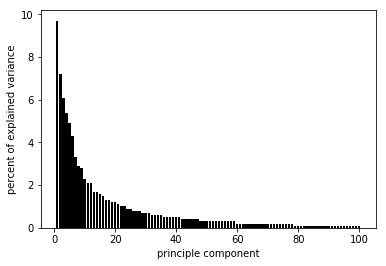

In [4]:
from sklearn.decomposition import PCA
pca = PCA()
scaled_data = pca.fit_transform(train)
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var) +1)]
plt.bar(x=range(1,len(per_var[:100])+1), height=per_var[:100], color='k')
plt.ylabel('percent of explained variance')
plt.xlabel('principle component')
plt.show()

In [7]:
scaler = MinMaxScaler()
Xtrain = scaler.fit_transform(pca_data)

In [8]:
Xtrain = pca_data[:,:60].T

In [9]:
ytrain = np.array(train['label'])
def hot_ones_numpy(y):
    Y = []
    odd = []
    for element in y:
        if element == 0:
            Y.append([1,0,0,0,0,0,0,0,0,0])
        elif element == 1:
            Y.append([0,1,0,0,0,0,0,0,0,0])
        elif element == 2:
            Y.append([0,0,1,0,0,0,0,0,0,0])
        elif element == 3:
            Y.append([0,0,0,1,0,0,0,0,0,0])
        elif element == 4:
            Y.append([0,0,0,0,1,0,0,0,0,0])
        elif element == 5:
            Y.append([0,0,0,0,0,1,0,0,0,0])
        elif element == 6:
            Y.append([0,0,0,0,0,0,1,0,0,0])
        elif element == 7:
            Y.append([0,0,0,0,0,0,0,1,0,0])
        elif element == 8:
            Y.append([0,0,0,0,0,0,0,0,1,0])
        elif element == 9:
            Y.append([0,0,0,0,0,0,0,0,0,1])
    return np.array(Y).T
Ytrain = hot_ones_numpy(ytrain)

In [86]:
Xtrainbatches = np.array_split(Xtrain,1,axis=1)
Ytrainbatches = np.array_split(Ytrain,1,axis=1)

In [87]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z))) 

In [88]:
def softmax(z):
    z_x = np.exp(z - np.max(z))
    return z_x / np.sum(z_x)

In [89]:
def Relu(z):
    return np.maximum(0, z)

In [90]:
def initialize_weights_biases(rows, columns):
    return np.random.randn(rows, columns) * np.sqrt(2/columns+rows), np.zeros(shape=(rows, 1))

In [91]:
def initialize_weights_biases2(rows, columns):
    return np.random.randn(rows, columns) * 0.1, np.zeros(shape=(rows, 1))

In [92]:
def compute_cost(A5, ytrue, m):
    msum = -1/m
    first_term = ytrue * np.log(A5)
    second_term = (1-ytrue) * np.log(1-A5) 
    summing_term = first_term + second_term
    cost = msum * np.sum(summing_term)
    cost = np.squeeze(cost)      
    return cost

In [93]:
W1,b1 = initialize_weights_biases(30, 60)
W2,b2 = initialize_weights_biases(10, 30)

In [94]:
def forprop(W, A, b):
    z = np.dot(W, A) + b
    return z

In [95]:
def forward_propogation(X,W1,b1,W2,b2):
    z1 = forprop(W1, X, b1)
    A1 = Relu(z1)
    z2 = forprop(W2, A1, b2)
    A2 = sigmoid(z2)
    return A2, A1

In [96]:
def backprop(W3, dZ3, A2, A1, W2, lambd, m):
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T) + lambd / m * W2
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    return dW2, db2

In [97]:
def backward_propogation(X, Y, A2, A1, lambd, m):
    dZ2 = A2 - Y
    dW2 = 1./m * np.dot(dZ2, A1.T) + lambd / m * W2
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    dW1, db1 = backprop(W2, dZ2, A1, X, W1, lambd, m)
    return dW2, db2, dW1, db1

In [98]:
def upparam(W, dW, b, db, Adam_cache, learning_rate, layer_no, m):
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    Adam_cache["VdW" + str(layer_no)] = beta1 * Adam_cache["VdW" + str(layer_no)] + (1 - beta1) * W
    Adam_cache["Vdb" + str(layer_no)] = beta1 * Adam_cache["Vdb" + str(layer_no)] + (1 - beta1) * b
    VdWcor = Adam_cache["VdW" + str(layer_no)] / (1 - beta1**m)
    Vdbcor = Adam_cache["Vdb" + str(layer_no)] / (1 - beta1**m)
    Adam_cache["SdW" + str(layer_no)] = beta2 * Adam_cache["SdW" + str(layer_no)] + (1 - beta2) * W**2
    Adam_cache["Sdb" + str(layer_no)] = beta2 * Adam_cache["Sdb" + str(layer_no)] + (1 - beta2) * b**2
    SdWcor = Adam_cache["SdW" + str(layer_no)] / (1 - beta2**m)
    Sdbcor = Adam_cache["Sdb" + str(layer_no)] / (1 - beta2**m)
    W = W - learning_rate * VdWcor / (np.sqrt(SdWcor) + epsilon)
    b = b - learning_rate * Vdbcor /(np.sqrt(Sdbcor) + epsilon)
    return W, b, Adam_cache

In [99]:
def initialize_Adam_values(weights, bias):
    return np.zeros_like(weights), np.zeros_like(bias)

In [100]:
Adam_cache ={'VdW1' : initialize_Adam_values(W1,b1)[0],
             'Vdb1' : initialize_Adam_values(W1,b1)[1],
             'SdW1' : initialize_Adam_values(W1,b1)[0],
             'Sdb1' : initialize_Adam_values(W1,b1)[1],
             'VdW2' : initialize_Adam_values(W2,b2)[0],
             'Vdb2' : initialize_Adam_values(W2,b2)[1],
             'SdW2' : initialize_Adam_values(W2,b2)[0],
             'Sdb2' : initialize_Adam_values(W2,b2)[1]}

In [101]:
def update_parameters(dW2, W2, db2, b2, dW1, W1, db1, b1, Adam_cache, learning_rate, m):
    W2, b2, Adam_cache = upparam(W2, dW2, b2, db2, Adam_cache, learning_rate, 2, m)
    W1, b1, Adam_cache = upparam(W1, dW1, b1, db1, Adam_cache, learning_rate, 1, m)
    return W1, b1, W2, b2

In [102]:
def test_accuracy(A2, Y, m):
    correct_counter = 0
    prediction = []
    for ele1, ele2 in zip(A2.T, Y.T):
        pred = list(ele1).index((max(ele1)))
        data = list(ele2).index((max(ele2)))
        prediction.append([pred, data])
        if pred == data:
            correct_counter +=1
    return correct_counter/m * 100, prediction

In [106]:
def Neural_network(X, Y, Adam_cache, W1, b1, W2, b2, learning_rate, number_iters, lambd):
    costs = []
    accuracy = []
    iteration = 0
    for i in range(number_iters):
        for j, (x, y) in enumerate(zip(X, Y)):
            m = x.shape[1]
            A2, A1 = forward_propogation(x,W1,b1,W2,b2)
            costs.append(compute_cost(A2, y, m))
            accuracy.append(test_accuracy(A2, y, m)[0])
            dW2, db2, dW1, db1 = backward_propogation(x, y, A2, A1, lambd, m)
            W1, b1, W2, b2 = update_parameters(dW2, W2, db2, b2, dW1, W1, db1, b1, Adam_cache, learning_rate, m)
            iteration +=1
            if iteration %100 == 0:
                print('current pass number', iteration, 'cost:', compute_cost(A2, y, m), 'accuracy:', test_accuracy(A2, y, m)[0])
    predictions = test_accuracy(A2, y, m)
    return W1, b1, W2, b2, costs, accuracy, predictions

In [111]:
W1, b1, W2, b2, costs, accuracy_score, predictions = Neural_network(Xtrainbatches, Ytrainbatches, Adam_cache, W1, b1, W2, b2, 0.003, 10, 0.01)

C:\Users\44788\.conda\envs\learning\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\Users\44788\.conda\envs\learning\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\44788\.conda\envs\learning\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\44788\.conda\envs\learning\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\44788\.conda\envs\learning\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


Text(0.5, 0, 'number of iterations')

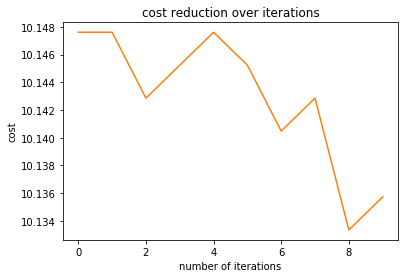

In [112]:
plt.plot(range(0,len(costs)), costs)
plt.plot(range(0,len(accuracy_score)), accuracy_score)
plt.title('cost reduction over iterations')
plt.ylabel('cost')
plt.xlabel('number of iterations')